# CS 6120 Final Project - Sentiment Analysis of U.S. Airline Reviews: LSTM and Naive Bayes Models
## Author： Yisong Cheng, Jiawen Gu


### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns


nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\schromeo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\schromeo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Load Data (Tweet.csv)

In [2]:
data = pd.read_csv('./Tweets.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

Text(0, 0.5, 'Count')

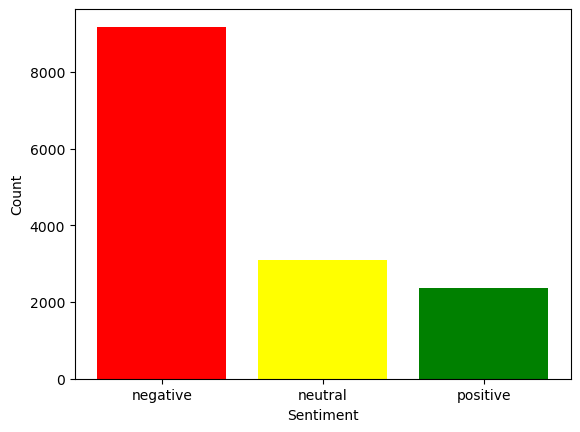

In [3]:
# Showing the distribution of airlines review
counter = data.airline_sentiment.value_counts()
index = [1,2,3]
plt.bar(index,counter,color=['red','yellow','green'])
plt.xticks(index,['negative','neutral','positive'])
plt.xlabel('Sentiment')
plt.ylabel('Count')

### Preprocessing Data

In [4]:

# Dropping columns with a large amount of null values
columns_to_drop = ['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord']
data_cleaned = data.drop(columns=columns_to_drop)

# define the stopwords and lemmatizer and stemmer
stop_words = set(stopwords.words('english'))

wn = WordNetLemmatizer()
ps = PorterStemmer()

In [5]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs and non-alphabetic characters using regex
    lower_text = re.sub(r'http\S+|www\S+|[^\w\s]', '', text)
    # Tokenize text
    tokens = word_tokenize(lower_text)
    # Remove stopwords and stem tokens
    tokens = [ps.stem(token) for token in tokens if token not in stop_words]
    # Lemmatize the words in the tokens list
    lemma_tokens = [wn.lemmatize(token) for token in tokens]
    lemma_text = ' '.join(lemma_tokens)
    return lemma_text

# apply preprocessing to texts
data_cleaned['text'] = data_cleaned['text'].apply(preprocess_text)


### Split the training/ test sets

In [6]:
# Split cleaned tweet text into words to prepare for Word2Vec training
sentences = [text.split() for text in data_cleaned['text']]

# Initialize and train a Word2Vec model to generate word embeddings for each unique word in the dataset
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
# Extract the word vectors from the trained model
word_vectors = model.wv

# Initialize a tokenizer to convert text to sequences of integers
keras_tokenizer = Tokenizer()
# Fit the tokenizer on the cleaned text data
keras_tokenizer.fit_on_texts(data_cleaned['text'])
# Convert texts to sequences of integers
sequences = keras_tokenizer.texts_to_sequences(data_cleaned['text'])

# Determine the maximum sequence length to standardize the length of input vectors
max_len = max([len(sequence) for sequence in sequences])
# Pad sequences to ensure uniform input size
X = pad_sequences(sequences, maxlen=max_len, padding='post')

# Create an embedding matrix to use in the neural network's embedding layer
# The matrix maps word indices to their corresponding word vectors from Word2Vec
embedding_matrix = np.zeros((len(keras_tokenizer.word_index) + 1, 100))
for word, i in keras_tokenizer.word_index.items():
    if word in word_vectors.key_to_index:
        embedding_matrix[i] = word_vectors[word]

# Initialize label encoder to convert categorical labels into numerical format
encoder = LabelEncoder()
# Encode sentiment labels
Y = encoder.fit_transform(data_cleaned['airline_sentiment'])
# Convert labels to one-hot encoding to fit the output of the neural network
Y = pd.get_dummies(Y).values

# Split data into training and testing sets with a test size of 20% and random state for reproducibility
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=32)




### Fit LSTM Model

In [7]:
# Initialize the LSTM model using the Sequential class
model_LSTM = Sequential()

# Add an embedding layer which uses the pre-trained word vectors from the embedding matrix
model_LSTM.add(Embedding(input_dim=len(keras_tokenizer.word_index) + 1,
                         output_dim=100,
                         weights=[embedding_matrix],  # Initialize with pre-trained word vectors
                         input_length=max_len,        # Set the input length to the maximum sequence length
                         trainable=False))            # The embeddings are not trained further

# Add an LSTM layer with 250 units, specifying dropout and recurrent dropout to prevent overfitting
model_LSTM.add(LSTM(250, dropout=0.3, recurrent_dropout=0.2))

# Add a dense output layer with 3 units (corresponding to the three sentiment classes) with softmax activation
# Softmax is used to output probabilities of the classes
model_LSTM.add(Dense(3, activation='softmax')) 

# Compile the model with categorical crossentropy loss function, Adam optimizer with a low learning rate, and track accuracy
model_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])


### Train LSTM Model for Testing

In [8]:
history = model_LSTM.fit(X_train, Y_train, batch_size=64, epochs=20, validation_data=(X_test, Y_test))

Epoch 1/20
183/183 [==============================] - 15s 74ms/step - loss: 0.8494 - accuracy: 0.6247 - val_loss: 0.7974 - val_accuracy: 0.6404
Epoch 2/20
183/183 [==============================] - 13s 73ms/step - loss: 0.7991 - accuracy: 0.6425 - val_loss: 0.7665 - val_accuracy: 0.6783
Epoch 3/20
183/183 [==============================] - 14s 74ms/step - loss: 0.7862 - accuracy: 0.6547 - val_loss: 0.7545 - val_accuracy: 0.6745
Epoch 4/20
183/183 [==============================] - 14s 74ms/step - loss: 0.7681 - accuracy: 0.6673 - val_loss: 0.7395 - val_accuracy: 0.6810
Epoch 5/20
183/183 [==============================] - 13s 73ms/step - loss: 0.7614 - accuracy: 0.6667 - val_loss: 0.7346 - val_accuracy: 0.6793
Epoch 6/20
183/183 [==============================] - 13s 73ms/step - loss: 0.7515 - accuracy: 0.6714 - val_loss: 0.7319 - val_accuracy: 0.6773
Epoch 7/20
183/183 [==============================] - 14s 74ms/step - loss: 0.7517 - accuracy: 0.6727 - val_loss: 0.7257 - val_accuracy:

### Visualization For LSTM Model Result

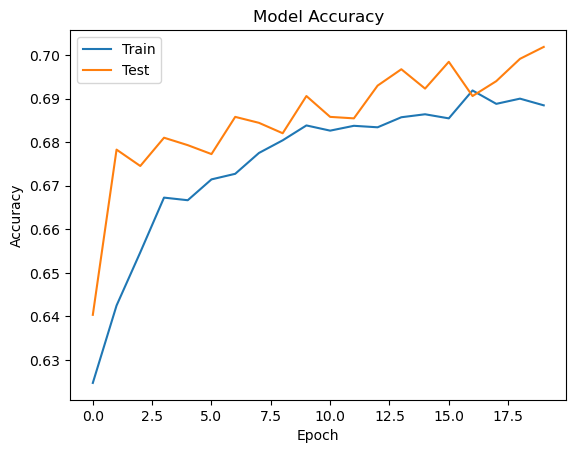

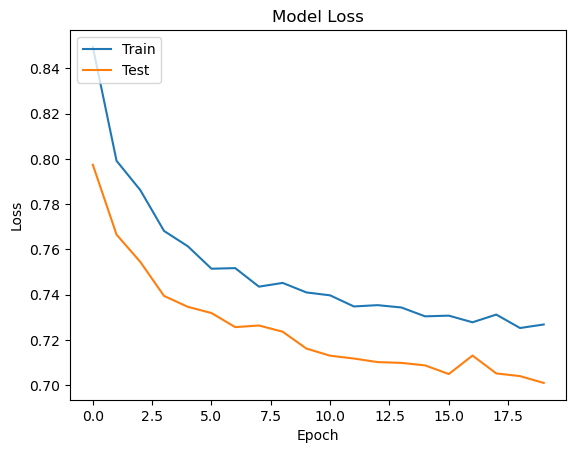

92/92 [==============================] - 2s 14ms/step
Accuracy for LSTM Model: 0.701844262295082
Classification Report for LSTM Model:
              precision    recall  f1-score   support

    negative       0.76      0.90      0.83      1868
     neutral       0.50      0.39      0.44       600
    positive       0.55      0.32      0.40       460

    accuracy                           0.70      2928
   macro avg       0.60      0.53      0.55      2928
weighted avg       0.68      0.70      0.68      2928



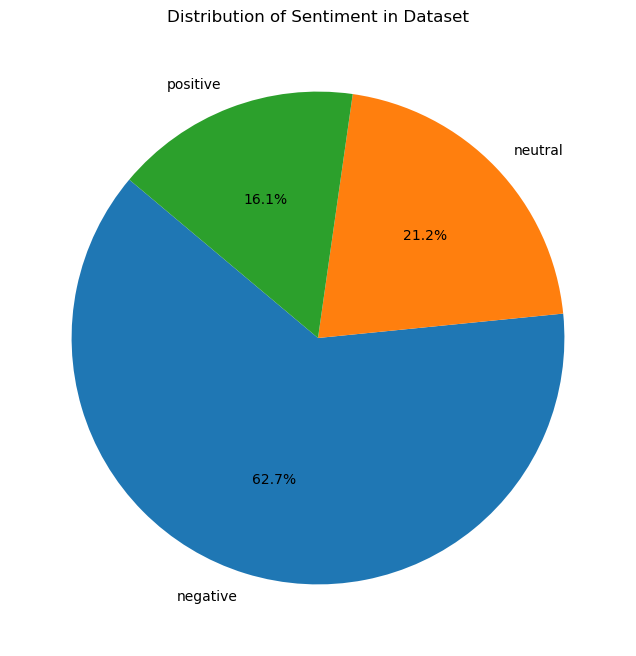

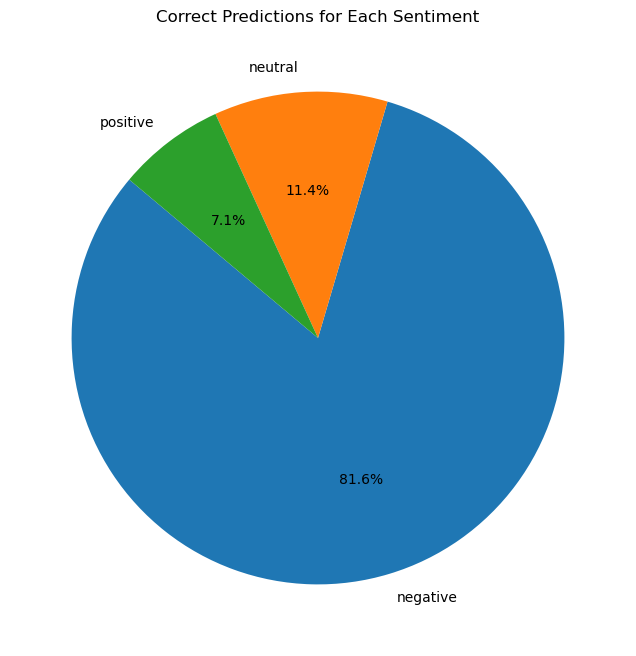

In [9]:
# Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Y_test_labels = np.argmax(Y_test, axis=1)
predictions_LSTM_labels = np.argmax(model_LSTM.predict(X_test), axis=1)

# Accuracy
accuracy_lstm = accuracy_score(Y_test_labels, predictions_LSTM_labels)
print("Accuracy for LSTM Model:", accuracy_lstm)

# Classification Report
print("Classification Report for LSTM Model:")
print(classification_report(Y_test_labels, predictions_LSTM_labels, target_names=encoder.classes_))

sentiment_counts = data_cleaned['airline_sentiment'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sentiment in Dataset')
plt.show()

from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(Y_test_labels, predictions_LSTM_labels)

# Calculate the number of correct predictions for each class
correct_predictions = np.diag(cm)

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(correct_predictions, labels=encoder.classes_, autopct='%1.1f%%', startangle=140)
plt.title('Correct Predictions for Each Sentiment')
plt.show()



### K-Folds Test For LSTM Model

In [10]:
fold_splits = 10
kf = KFold(n_splits=fold_splits, shuffle=True, random_state=32)

fold_num = 1
accuracy_per_fold = []
loss_per_fold = []

for train_index, test_index in kf.split(X):
    # split training and testing set
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    # Creating the LSTM modeal
    model = Sequential([
        Embedding(input_dim=len(keras_tokenizer.word_index) + 1, output_dim=100, weights=[embedding_matrix], input_length=max_len),
        LSTM(250, dropout=0.3, recurrent_dropout=0.2),
        Dense(3, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
    
    # train model
    history = model.fit(X_train, Y_train, batch_size=64, epochs=20, validation_data=(X_test, Y_test), verbose=0)
    
    # record evaluation
    scores = model.evaluate(X_test, Y_test, verbose=0)
    print(f'Score for fold {fold_num}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    accuracy_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    fold_num += 1

# print out the average loss and accuracy
print(f'Average scores for all {fold_splits} folds:\n> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})\n> Loss: {np.mean(loss_per_fold)}')

Score for fold 1: loss of 0.6362675428390503; accuracy of 75.68305730819702%
Score for fold 2: loss of 0.708564817905426; accuracy of 77.25409865379333%
Score for fold 3: loss of 0.6238672137260437; accuracy of 77.45901346206665%
Score for fold 4: loss of 0.6246695518493652; accuracy of 77.45901346206665%
Score for fold 5: loss of 0.665093719959259; accuracy of 77.59562730789185%
Score for fold 6: loss of 0.635239839553833; accuracy of 76.63934230804443%
Score for fold 7: loss of 0.6603451371192932; accuracy of 79.30327653884888%
Score for fold 8: loss of 0.620983362197876; accuracy of 78.89344096183777%
Score for fold 9: loss of 0.6819719672203064; accuracy of 76.50273442268372%
Score for fold 10: loss of 0.678119957447052; accuracy of 76.70764923095703%
Average scores for all 10 folds:
> Accuracy: 77.34972536563873 (+- 1.0346497938893113)
> Loss: 0.6535123109817504


### Fit and Train the Multinomial Naive Bayes by K-Folds

Fold 1
              precision    recall  f1-score   support

    negative       0.80      0.94      0.87       916
     neutral       0.65      0.41      0.51       299
    positive       0.75      0.58      0.65       249

    accuracy                           0.77      1464
   macro avg       0.73      0.65      0.67      1464
weighted avg       0.76      0.77      0.76      1464



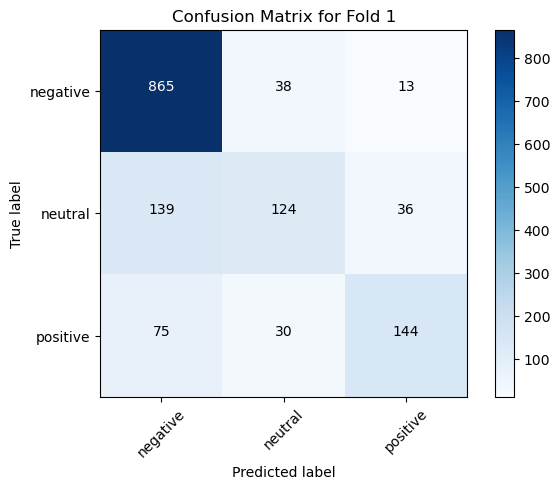

Fold 2
              precision    recall  f1-score   support

    negative       0.81      0.93      0.87       952
     neutral       0.66      0.43      0.52       301
    positive       0.66      0.55      0.60       211

    accuracy                           0.77      1464
   macro avg       0.71      0.64      0.66      1464
weighted avg       0.76      0.77      0.76      1464



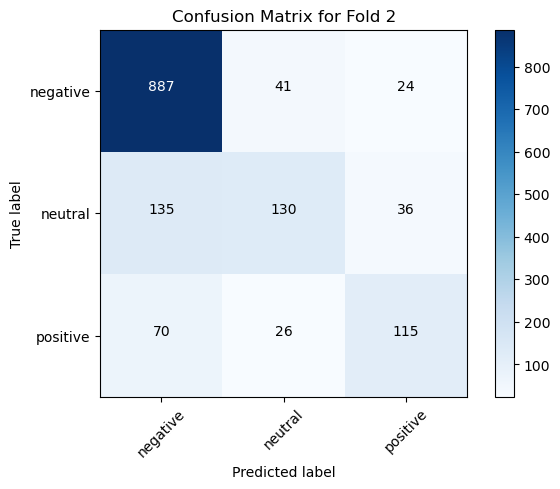

Fold 3
              precision    recall  f1-score   support

    negative       0.79      0.93      0.86       926
     neutral       0.67      0.42      0.52       315
    positive       0.78      0.62      0.69       223

    accuracy                           0.77      1464
   macro avg       0.75      0.66      0.69      1464
weighted avg       0.76      0.77      0.76      1464



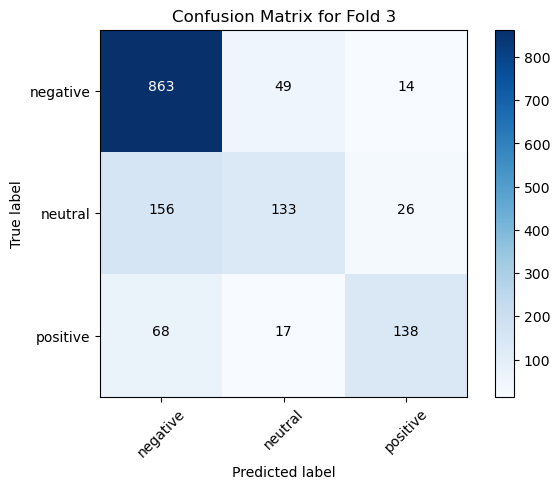

Fold 4
              precision    recall  f1-score   support

    negative       0.79      0.92      0.85       915
     neutral       0.64      0.43      0.52       314
    positive       0.76      0.61      0.68       235

    accuracy                           0.77      1464
   macro avg       0.73      0.66      0.68      1464
weighted avg       0.76      0.77      0.75      1464



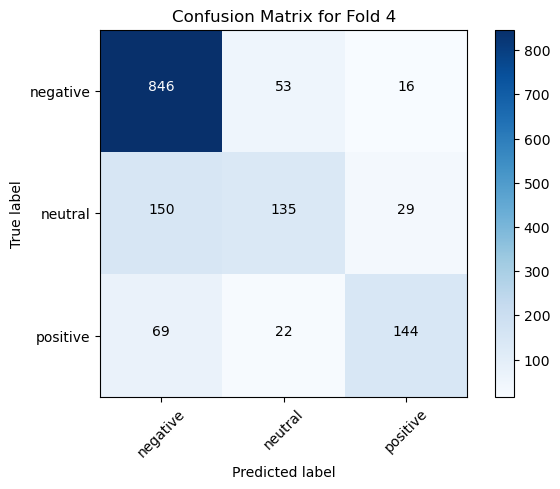

Fold 5
              precision    recall  f1-score   support

    negative       0.79      0.93      0.85       911
     neutral       0.68      0.44      0.53       320
    positive       0.77      0.57      0.66       233

    accuracy                           0.77      1464
   macro avg       0.74      0.65      0.68      1464
weighted avg       0.76      0.77      0.75      1464



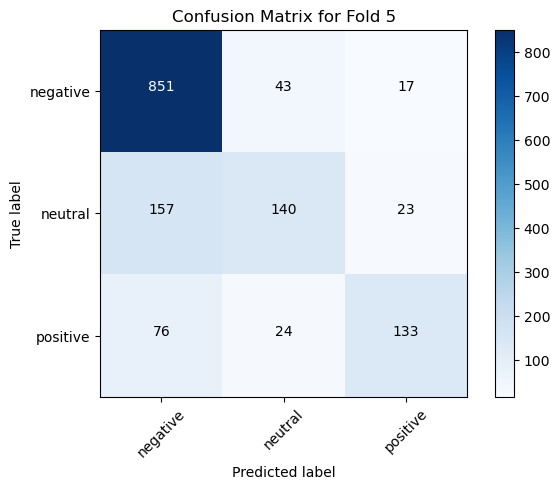

Fold 6
              precision    recall  f1-score   support

    negative       0.79      0.92      0.85       909
     neutral       0.63      0.40      0.49       306
    positive       0.68      0.55      0.61       249

    accuracy                           0.75      1464
   macro avg       0.70      0.63      0.65      1464
weighted avg       0.74      0.75      0.73      1464



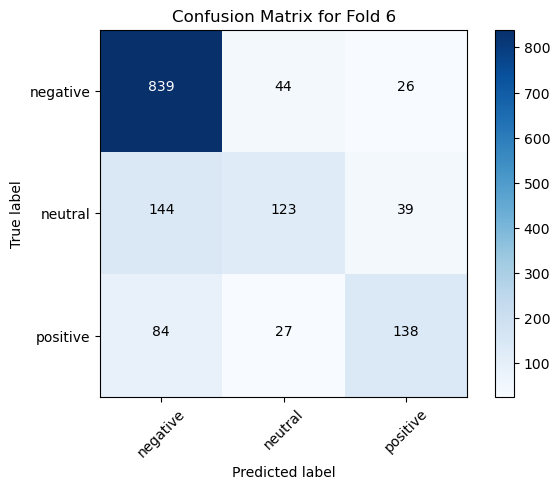

Fold 7
              precision    recall  f1-score   support

    negative       0.77      0.93      0.84       909
     neutral       0.62      0.41      0.49       298
    positive       0.77      0.51      0.61       257

    accuracy                           0.75      1464
   macro avg       0.72      0.62      0.65      1464
weighted avg       0.74      0.75      0.73      1464



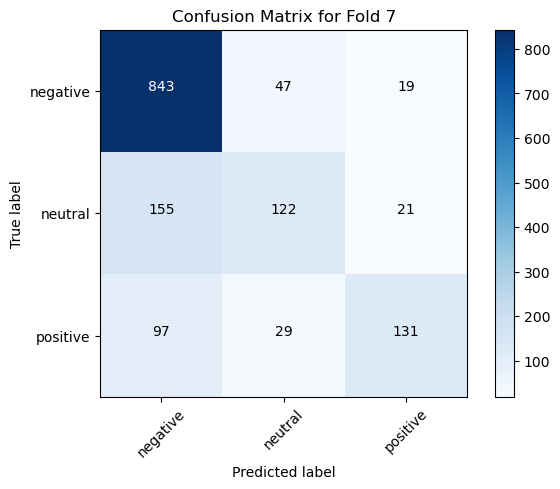

Fold 8
              precision    recall  f1-score   support

    negative       0.80      0.95      0.87       918
     neutral       0.68      0.43      0.52       305
    positive       0.77      0.58      0.66       241

    accuracy                           0.78      1464
   macro avg       0.75      0.65      0.68      1464
weighted avg       0.77      0.78      0.76      1464



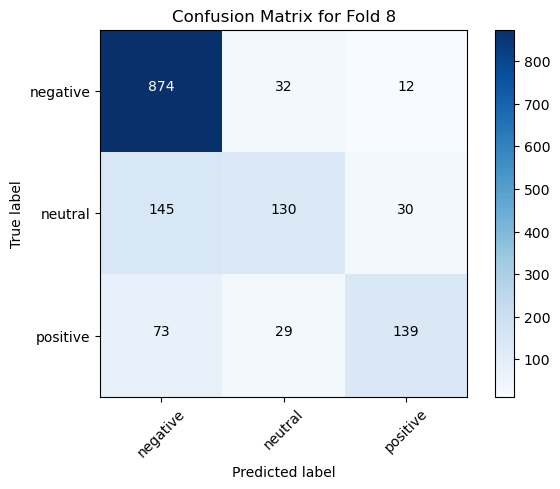

Fold 9
              precision    recall  f1-score   support

    negative       0.81      0.93      0.86       907
     neutral       0.66      0.43      0.52       313
    positive       0.75      0.66      0.70       244

    accuracy                           0.78      1464
   macro avg       0.74      0.67      0.70      1464
weighted avg       0.76      0.78      0.76      1464



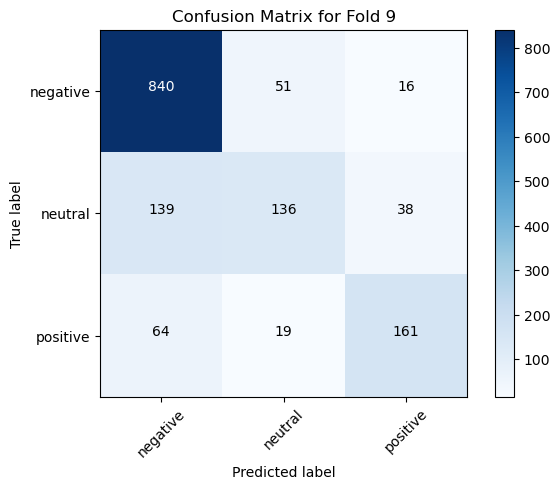

Fold 10
              precision    recall  f1-score   support

    negative       0.77      0.93      0.84       915
     neutral       0.68      0.39      0.50       328
    positive       0.70      0.56      0.62       221

    accuracy                           0.75      1464
   macro avg       0.72      0.62      0.65      1464
weighted avg       0.74      0.75      0.73      1464



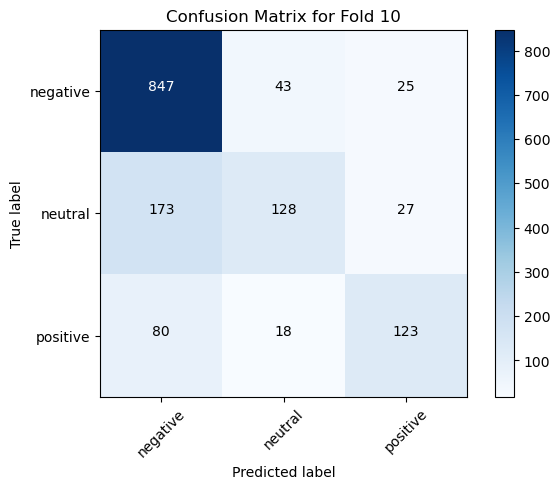

Average Accuracy: 0.7665300546448088
Average Precision: 0.7546764074206354
Average Recall: 0.7665300546448088
Average F1 Score: 0.7497355696495958


In [11]:

cv = CountVectorizer()
X = cv.fit_transform(data_cleaned['text'])
Y = encoder.fit_transform(data_cleaned['airline_sentiment'])

fold_splits = 10
kf = KFold(n_splits=fold_splits, shuffle=True, random_state=32)

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Labeling the plot
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Initialize lists to store the metrics
acc_scores, precisions, recalls, f1_scores = [], [], [], []

fold_num = 1  # To track which fold is currently being processed

# Iterate over each split
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    # Train the Multinomial Naive Bayes model
    nb_model = MultinomialNB()
    nb_model.fit(X_train, Y_train)
    
    # Make predictions
    Y_pred = nb_model.predict(X_test)
    
    # Evaluate the model
    acc_scores.append(accuracy_score(Y_test, Y_pred))
    precision, recall, f1, _ = precision_recall_fscore_support(Y_test, Y_pred, average='weighted')
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    print(f'Fold {fold_num}')
    print(classification_report(Y_test, Y_pred, target_names=encoder.classes_))
    
    # Generate the confusion matrix and plot it
    cm = confusion_matrix(Y_test, Y_pred)
    plot_confusion_matrix(cm, classes=encoder.classes_, title=f'Confusion Matrix for Fold {fold_num}')
    
    fold_num += 1  # Increment the fold number

# Print the average accuracy over all folds
print("Average Accuracy:", np.mean(acc_scores))

print("Average Precision:", np.mean(precisions))
print("Average Recall:", np.mean(recalls))
print("Average F1 Score:", np.mean(f1_scores))

### Testing models with sample text

In [12]:
def predict_sentiment_lstm(text):

    # Preprocess the input text
    preprocessed_text = preprocess_text(text)
    # Tokenize and pad the text to make it compatible with the model input
    sequence = keras_tokenizer.texts_to_sequences([preprocessed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post')
    # Predict sentiment
    prediction = model_LSTM.predict(padded_sequence)
    # Decode the prediction
    sentiment = encoder.inverse_transform([np.argmax(prediction)])
    return sentiment[0]
    
def predict_sentiment_nb(text):
    # Preprocess the input text
    preprocessed_text = preprocess_text(text)
    # Vectorize the text
    vectorized_text = cv.transform([preprocessed_text])
    # Predict sentiment
    prediction = nb_model.predict(vectorized_text)
    # Decode the prediction
    sentiment = encoder.inverse_transform(prediction)
    return sentiment[0]

In [13]:
input_text1 = "I had a terrible flight experience. The flight was delayed and the staff were rude."
print("LSTM Model Prediction:", predict_sentiment_lstm(input_text1))
print("Naive Bayes Model Prediction:", predict_sentiment_nb(input_text1))


1/1 [==============================] - 0s 25ms/step
LSTM Model Prediction: negative
Naive Bayes Model Prediction: negative


In [14]:
input_text2 = "Fantastic!The staff were incredibly friendly and the seats were very comfortable. I'm looking forward to flying with them again!"
print("LSTM Model Prediction:", predict_sentiment_lstm(input_text2))
print("Naive Bayes Model Prediction:", predict_sentiment_nb(input_text2))

1/1 [==============================] - 0s 32ms/step
LSTM Model Prediction: negative
Naive Bayes Model Prediction: positive


In [15]:
input_text3 = "United Airline's meal tasting good and has wifi on the flight."
print("LSTM Model Prediction:", predict_sentiment_lstm(input_text3))
print("Naive Bayes Model Prediction:", predict_sentiment_nb(input_text3))

1/1 [==============================] - 0s 30ms/step
LSTM Model Prediction: positive
Naive Bayes Model Prediction: negative


In [16]:
input_text4 = "I don't know but whatever."
print("LSTM Model Prediction:", predict_sentiment_lstm(input_text4))
print("Naive Bayes Model Prediction:", predict_sentiment_nb(input_text4))

1/1 [==============================] - 0s 32ms/step
LSTM Model Prediction: neutral
Naive Bayes Model Prediction: negative
